In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load dataset
df = pd.read_excel("C:/Users/ranje/OneDrive/Desktop/Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove cancelled orders (InvoiceNo starts with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Keep only positive quantities and prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [3]:
# Create Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Latest date in dataset
latest_date = df['InvoiceDate'].max()

# Build RFM table
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID','Recency','Frequency','Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


In [4]:
# Scale values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])


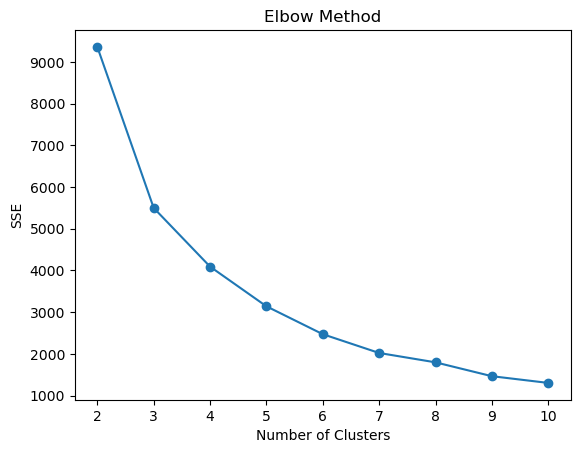

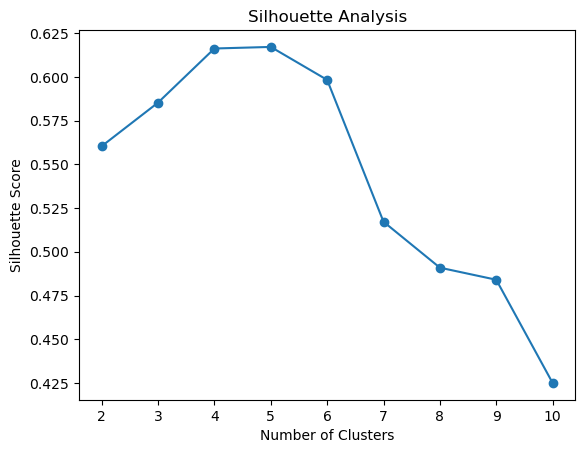

In [5]:
sse = []
sil = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)
    sil.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot elbow method
plt.plot(range(2,11), sse, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()

# Plot silhouette scores
plt.plot(range(2,11), sil, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


In [6]:
# Fit KMeans with chosen k (example k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.groupby('Cluster').mean()


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15289.128356,42.702685,3.682711,1359.049284
1,15347.791940,247.075914,1.552015,480.617480
2,15435.000000,6.384615,82.538462,127338.313846
3,15212.857843,14.500000,22.333333,12709.090490


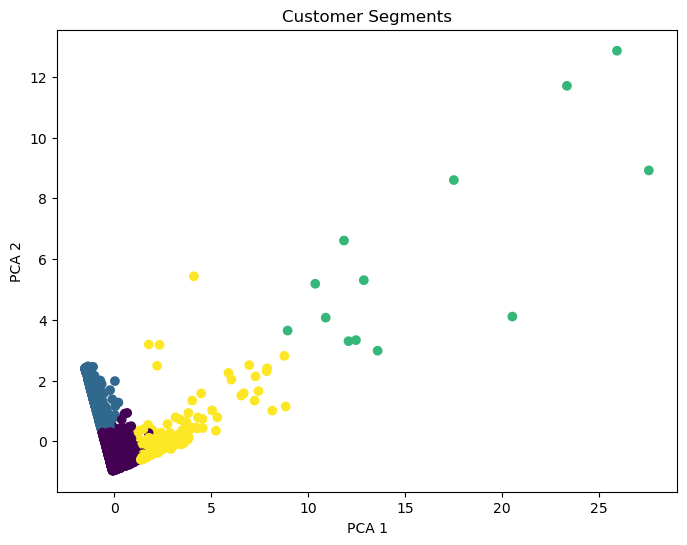

In [7]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0], pca_data[:,1], c=rfm['Cluster'], cmap='viridis')
plt.title("Customer Segments")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()
